# Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

# Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 2

# Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../Dataset/CancerDetection",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3297 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['benign', 'malignant']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0]


# Visualize some of the images from our dataset

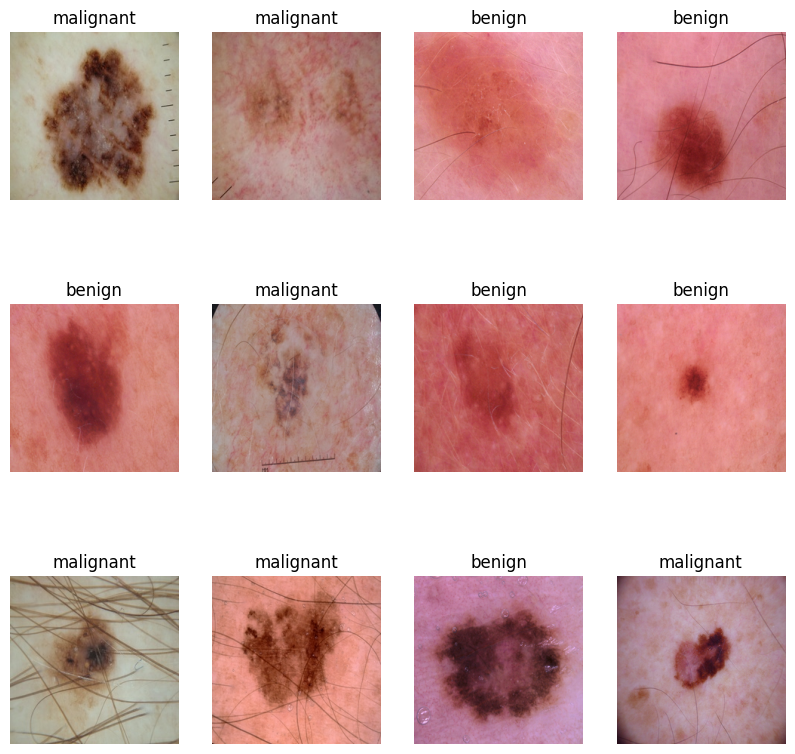

In [6]:
plt.figure(figsize=(10, 10))

for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Function to Split Dataset

## Dataset should be bifurcated into 3 subsets, namely:

    1. Training: Dataset to be used while training
    2. Validation: Dataset to be tested against while training
    3. Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)

104

In [8]:
train_size = 0.8
len(dataset)*train_size

83.2

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

50

In [11]:
val_size=0.1
len(dataset)*val_size

10.4

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

44

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

83

In [17]:
len(val_ds)

10

In [18]:
len(test_ds)

11

In [19]:
actual_label_test = []

for image_batch, labels_batch in test_ds:
    temp = labels_batch.numpy()
    for j in temp:
        actual_label_test.append(j)
    
# print(len(actual_label_test))
# print(actual_label_test)

# Cache, Shuffle, and Prefetch the Dataset

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

## Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
# Data Augmentation
# Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

# data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#   layers.experimental.preprocessing.RandomRotation(0.2),
# ])

# Applying Data Augmentation to Train Dataset
# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture

###  We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

# Compiling the Model

### We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [25]:
import time
t0 = time.time()

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS,
)

Epoch 1/2
83/83 [==============================] - 105s 1s/step - loss: 0.5602 - accuracy: 0.6954 - val_loss: 0.5226 - val_accuracy: 0.7688
Epoch 2/2
83/83 [==============================] - 109s 1s/step - loss: 0.4850 - accuracy: 0.7575 - val_loss: 0.5315 - val_accuracy: 0.7781


In [28]:
t1 = time.time()

# Training Speed

In [29]:
print("CNN Model Training time:  ", (t1-t0)/60 , "minutes")

CNN Model Training time:   3.559934957822164 minutes


# Evaluation

In [30]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 8s 319ms/step - loss: 0.5149 - accuracy: 0.7841


In [31]:
scores

[0.5148727893829346, 0.7840909361839294]

# Predictions

In [32]:
predicted = model.predict(test_ds)

11/11 [==============================] - 4s 308ms/step


In [33]:
import numpy as np

confidence = np.max(predicted, axis=1)
predictions = np.argmax(predicted, axis=1)

In [34]:
# predicted

# print(predicted)
print(len(predicted))
print(len(test_ds))

# print(predictions)
print(len(predictions))

352
11
352


# Plotting History

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

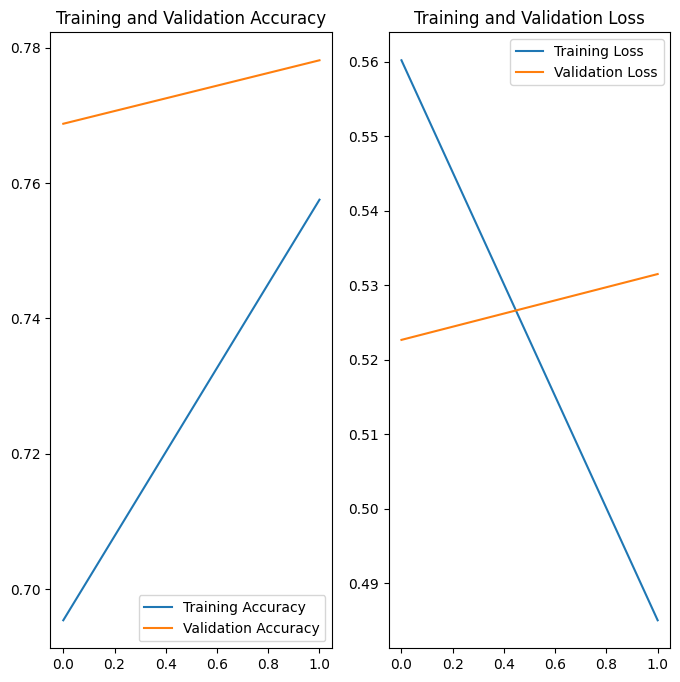

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

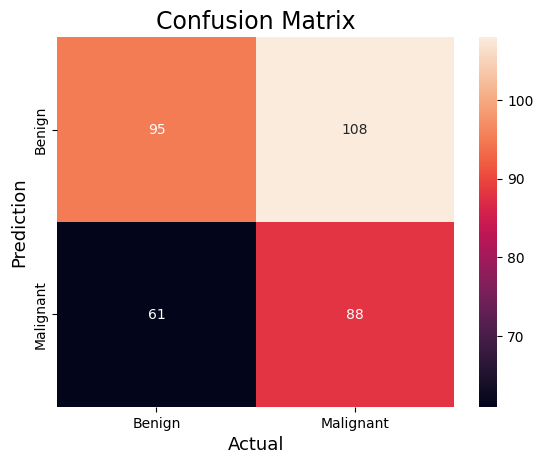

In [38]:
cm = confusion_matrix(actual_label_test, predictions)


sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=['Benign','Malignant'],
    yticklabels=['Benign','Malignant']
)

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [39]:
from sklearn.metrics import classification_report
print(classification_report(actual_label_test, predictions))

              precision    recall  f1-score   support

           0       0.61      0.47      0.53       203
           1       0.45      0.59      0.51       149

    accuracy                           0.52       352
   macro avg       0.53      0.53      0.52       352
weighted avg       0.54      0.52      0.52       352



# Saving the Model
### We append the model to the list of models as a new version

In [40]:
import os
model_version=max([int(i) for i in os.listdir("../savedmodels") + [0]])+1
model.save(f"../savedmodels/{model_version}")

INFO:tensorflow:Assets written to: ../savedmodels/5\assets


INFO:tensorflow:Assets written to: ../savedmodels/5\assets
